# MMA Fight Outcome Model

The purpose of this project is to create a binary classification model to predict the outcome of an MMA fight (win or loss for a given fighter) based on a set of features extracted from the database found at https://www.kaggle.com/datasets/danmcinerney/mma-differentials-and-elo?select=masterMLpublic.csv

The database consists of over 6000 unique fights and 513 feature columns for which data is collected on each fight. This project will explore two distinct models. The first will tackle the problem using a feed-forward neural network, whereas the second model will utilise an SVM classifier.

#### For more information on the problem statement and methodology, please read Summary.pdf or README.md

## I. DATA PREPROCESSING

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# REMOVING ENTRIES WITH MISSING DATA

data = pd.read_csv('masterdataframe.csv')
data = data.dropna()
start_col = data.columns.get_loc("reach") 
end_col = data.columns.get_loc("precomp_recent_avg_ground_strikes_attempts_per_min") + 1  
features = data.iloc[:, start_col:end_col]
target = data['result']  

# SPLITTING DATA INTO TRAINING, VALIDATION, TESTING SETS

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# NORMALISING

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Example visualisation of processed data for feature 200

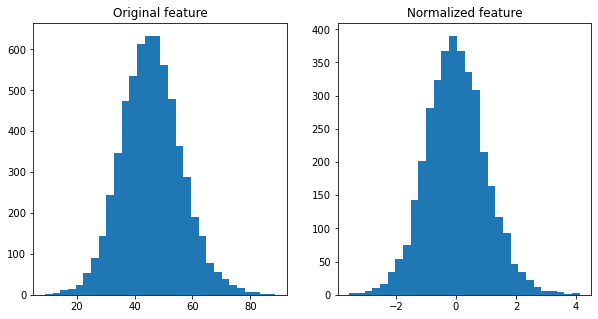

In [11]:
import matplotlib.pyplot as plt

feature_idx = 200  # Choose the index of the feature you want to plot
original_feature = data.iloc[:, start_col + feature_idx]
normalized_feature = X_train[:, feature_idx]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(original_feature, bins=30)
plt.title('Original feature')
plt.subplot(1, 2, 2)
plt.hist(normalized_feature, bins=30)
plt.title('Normalized feature')
plt.show()


## II. DEVELOPING MODEL 1: LOGISTIC REGRESSION AND A NEURAL NETWORK

### Least Squares Approximation using LU Factorisation

In [12]:
import scipy.linalg as la

X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

alpha = 1e-3  # Regularization strength 
XtX = X_train.T @ X_train + alpha * np.eye(X_train.shape[1])


# XtX = X_train.T @ X_train
Xty = X_train.T @ y_train

# LU Factorization
P, L, U = la.lu(XtX)

# Forward substitution
y_temp = la.solve(L, P @ Xty)

# Backward substitution
w = la.solve(U, y_temp)

def logistic_function(x):
    return 1 / (1 + np.exp(-x))

y_train_pred = logistic_function(X_train @ w)
y_val_pred = logistic_function(X_val @ w)
y_test_pred = logistic_function(X_test @ w)


threshold = 0.5
y_train_pred_label = (y_train_pred >= threshold).astype(int)
y_val_pred_label = (y_val_pred >= threshold).astype(int)
y_test_pred_label = (y_test_pred >= threshold).astype(int)


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_train = accuracy_score(y_train, y_train_pred_label)
precision_train = precision_score(y_train, y_train_pred_label)
recall_train = recall_score(y_train, y_train_pred_label)
f1_train = f1_score(y_train, y_train_pred_label)

accuracy_val = accuracy_score(y_val, y_val_pred_label)
precision_val = precision_score(y_val, y_val_pred_label)
recall_val = recall_score(y_val, y_val_pred_label)
f1_val = f1_score(y_val, y_val_pred_label)

accuracy_test = accuracy_score(y_test, y_test_pred_label)
precision_test = precision_score(y_test, y_test_pred_label)
recall_test = recall_score(y_test, y_test_pred_label)
f1_test = f1_score(y_test, y_test_pred_label)

print("Training set evaluation:")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 score: {f1_train:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1 score: {f1_val:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 score {f1_test:.3f}")


Training set evaluation:
Accuracy: 0.493
Precision: 0.490
Recall: 0.510
F1 score: 0.500

Validation set evaluation:
Accuracy: 0.510
Precision: 0.506
Recall: 0.500
F1 score: 0.503

Test set evaluation:
Accuracy: 0.517
Precision: 0.505
Recall: 0.541
F1 score 0.522


### Refining the Logistic Regression: Elastic Net Regularisation

In [14]:
from sklearn.linear_model import SGDClassifier

# Prepare the data
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Set regularization hyperparameters
alpha = 1e-3  # Regularization strength
l1_ratio = 0.5  # Ratio between L1 and L2 regularization

# Train the Elastic Net regularized logistic regression model
model = SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio, random_state=42)
model.fit(X_train, y_train)

# Predict labels and probabilities
y_train_pred_label = model.predict(X_train)
y_train_pred = model.predict_proba(X_train)[:, 1]

y_val_pred_label = model.predict(X_val)
y_val_pred = model.predict_proba(X_val)[:, 1]

y_test_pred_label = model.predict(X_test)
y_test_pred = model.predict_proba(X_test)[:, 1]

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_train = accuracy_score(y_train, y_train_pred_label)
precision_train = precision_score(y_train, y_train_pred_label)
recall_train = recall_score(y_train, y_train_pred_label)
f1_train = f1_score(y_train, y_train_pred_label)

accuracy_val = accuracy_score(y_val, y_val_pred_label)
precision_val = precision_score(y_val, y_val_pred_label)
recall_val = recall_score(y_val, y_val_pred_label)
f1_val = f1_score(y_val, y_val_pred_label)

accuracy_test = accuracy_score(y_test, y_test_pred_label)
precision_test = precision_score(y_test, y_test_pred_label)
recall_test = recall_score(y_test, y_test_pred_label)
f1_test = f1_score(y_test, y_test_pred_label)

print("Training set evaluation:")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 score: {f1_train:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1 score: {f1_val:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 score {f1_test:.3f}")


Training set evaluation:
Accuracy: 0.862
Precision: 0.851
Recall: 0.875
F1 score: 0.863

Validation set evaluation:
Accuracy: 0.821
Precision: 0.827
Recall: 0.807
F1 score: 0.817

Test set evaluation:
Accuracy: 0.811
Precision: 0.805
Recall: 0.808
F1 score 0.806


### Introducing a Feed-foward Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Identify significant independent variables
significant_variables = np.where(np.abs(w[1:]) > 1e-2)[0]  # Adjust the threshold as needed
X_train_nn = X_train[:, 1:][:, significant_variables]
X_val_nn = X_val[:, 1:][:, significant_variables]
X_test_nn = X_test[:, 1:][:, significant_variables]

# Add logistic regression predictions as an input
X_train_nn = np.hstack([X_train_nn, y_train_pred.reshape(-1, 1)])
X_val_nn = np.hstack([X_val_nn, y_val_pred.reshape(-1, 1)])
X_test_nn = np.hstack([X_test_nn, y_test_pred.reshape(-1, 1)])

# Create a simple feedforward neural network
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(X_train_nn.shape[1],)))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_data=(X_val_nn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_nn, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Epoch 1/50
114/114 [==============================] - 1s 3ms/step - loss: 0.5456 - accuracy: 0.4964 - val_loss: 0.4575 - val_accuracy: 0.4955
Epoch 2/50
114/114 [==============================] - 0s 1ms/step - loss: 0.4301 - accuracy: 0.4964 - val_loss: 0.4297 - val_accuracy: 0.4955
Epoch 3/50
114/114 [==============================] - 0s 1ms/step - loss: 0.4014 - accuracy: 0.4964 - val_loss: 0.4095 - val_accuracy: 0.4955
Epoch 4/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3848 - accuracy: 0.4964 - val_loss: 0.3966 - val_accuracy: 0.4955
Epoch 5/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3745 - accuracy: 0.4964 - val_loss: 0.3946 - val_accuracy: 0.4955
Epoch 6/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3663 - accuracy: 0.4964 - val_loss: 0.3909 - val_accuracy: 0.4955
Epoch 7/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.4964 - val_loss: 0.3950 - val_accuracy: 0.4955
Epoch 

### Evaluation

38/38 [==============================] - 0s 711us/step
Training set evaluation:
Accuracy: 0.496
Precision: 0.496
Recall: 1.000
F1 score: 0.663

Validation set evaluation:
Accuracy: 0.495
Precision: 0.495
Recall: 1.000
F1 score: 0.663

Test set evaluation:
Accuracy: 0.488
Precision: 0.488
Recall: 1.000
F1 score 0.656


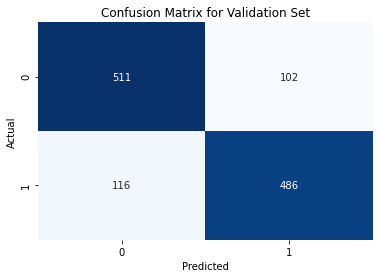

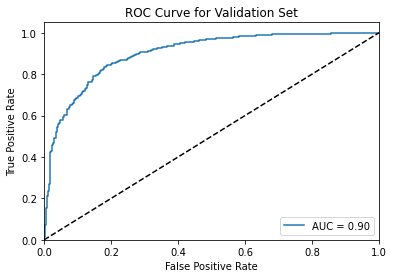

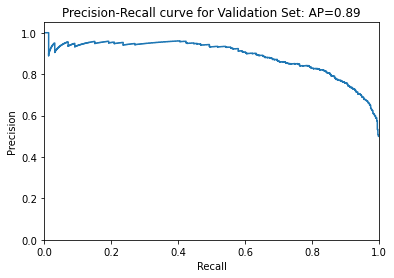

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, plot_confusion_matrix

# Get the predictions from the hybrid model
y_train_pred_nn = model.predict(X_train_nn)
y_val_pred_nn = model.predict(X_val_nn)
y_test_pred_nn = model.predict(X_test_nn)

# Apply the threshold
threshold = 0.5
y_train_pred_label_nn = (y_train_pred_nn >= threshold).astype(int)
y_val_pred_label_nn = (y_val_pred_nn >= threshold).astype(int)
y_test_pred_label_nn = (y_test_pred_nn >= threshold).astype(int)

# Calculate the evaluation metrics
accuracy_train_nn = accuracy_score(y_train, y_train_pred_label_nn)
precision_train_nn = precision_score(y_train, y_train_pred_label_nn)
recall_train_nn = recall_score(y_train, y_train_pred_label_nn)
f1_train_nn = f1_score(y_train, y_train_pred_label_nn)

accuracy_val_nn = accuracy_score(y_val, y_val_pred_label_nn)
precision_val_nn = precision_score(y_val, y_val_pred_label_nn)
recall_val_nn = recall_score(y_val, y_val_pred_label_nn)
f1_val_nn = f1_score(y_val, y_val_pred_label_nn)

accuracy_test_nn = accuracy_score(y_test, y_test_pred_label_nn)
precision_test_nn = precision_score(y_test, y_test_pred_label_nn)
recall_test_nn = recall_score(y_test, y_test_pred_label_nn)
f1_test_nn = f1_score(y_test, y_test_pred_label_nn)

# Print the evaluation results
print("Training set evaluation:")
print(f"Accuracy: {accuracy_train_nn:.3f}")
print(f"Precision: {precision_train_nn:.3f}")
print(f"Recall: {recall_train_nn:.3f}")
print(f"F1 score: {f1_train_nn:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val_nn:.3f}")
print(f"Precision: {precision_val_nn:.3f}")
print(f"Recall: {recall_val_nn:.3f}")
print(f"F1 score: {f1_val_nn:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test_nn:.3f}")
print(f"Precision: {precision_test_nn:.3f}")
print(f"Recall: {recall_test_nn:.3f}")
print(f"F1 score {f1_test_nn:.3f}")



cm = confusion_matrix(y_val, y_val_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()

y_val_proba = y_val_pred  # Use predicted probabilities from the logistic function

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve for Validation Set: AP={average_precision:.2f}')
plt.show()


## III. DEVELOPING MODEL 2: SVM Classifier using QR Factorisation

### Performing the QR Decomposition

In [ ]:
from scipy.stats import uniform, randint
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.linalg import qr

# Perform QR factorization on the training data
Q_train, R_train = qr(X_train)

# Transform the validation data using the R matrix obtained from the training data
X_val_transformed = np.dot(X_val, np.linalg.inv(R_train[:X_val.shape[1], :]))

# Transform the test data using the R matrix obtained from the training data
X_test_transformed = np.dot(X_test, np.linalg.inv(R_train[:X_test.shape[1], :]))

### Refining the Parameters

In [121]:
param_dist = {
    'C': uniform(loc=0, scale=4),
    'gamma': uniform(loc=0, scale=0.1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(2, 6),
    'coef0': uniform(loc=0, scale=1)
}

from sklearn.model_selection import RandomizedSearchCV

svm_classifier = SVC()

random_search = RandomizedSearchCV(
    svm_classifier,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_val_transformed, y_val)

from sklearn.feature_selection import RFECV

svm_classifier_best = random_search.best_estimator_

rfe_cv = RFECV(svm_classifier_best, step=5, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
rfe_cv.fit(X_val_transformed, y_val)


print("Optimal number of features : %d" % rfe_cv.n_features_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting estimator with 515 features.
Fitting estimator with 510 features.
Fitting estimator with 505 features.
Fitting estimator with 500 features.
Fitting estimator with 495 features.
Fitting estimator with 490 features.
Fitting estimator with 485 features.
Fitting estimator with 480 features.
Fitting estimator with 475 features.
Fitting estimator with 470 features.
Fitting estimator with 465 features.
Fitting estimator with 460 features.
Fitting estimator with 455 features.
Fitting estimator with 450 features.
Fitting estimator with 445 features.
Fitting estimator with 440 features.
Fitting estimator with 435 features.
Fitting estimator with 430 features.
Fitting estimator with 425 features.
Fitting estimator with 420 features.
Fitting estimator with 415 features.
Fitting estimator with 410 features.
Fitting estimator with 405 features.
Fitting estimator with 400 features.
Fitting estimator with 395 features.
Fitting estimator with 390 features.
Fitting estimator with 385 features.
F

In [123]:
importances = rfe_cv.grid_scores_
indices = np.argsort(importances)[::-1]
column_names = features.columns

print("Feature Ranking (Top 30):")

for i in range(30):
    index = indices[i]
    column_name = column_names[index]
    importance = importances[index]
    print(f"{i + 1}. {column_name} (Importance: {importance:.4f})")




Feature Ranking (Top 30):
1. control (Importance: 0.7868)
2. sub_attempts (Importance: 0.7844)
3. reversals (Importance: 0.7827)
4. takedowns_landed (Importance: 0.7770)
5. takedowns_attempts (Importance: 0.7704)
6. knockdowns (Importance: 0.7679)
7. sig_strikes_attempts (Importance: 0.7663)
8. sig_strikes_landed (Importance: 0.7621)
9. age (Importance: 0.7588)
10. total_strikes_landed (Importance: 0.7547)
11. leg_strikes_landed (Importance: 0.7481)
12. body_strikes_attempts (Importance: 0.7473)
13. head_strikes_attempts (Importance: 0.7473)
14. leg_strikes_attempts (Importance: 0.7449)
15. body_strikes_landed (Importance: 0.7449)
16. distance_strikes_attempts (Importance: 0.7416)
17. distance_strikes_landed (Importance: 0.7407)
18. total_strikes_attempts (Importance: 0.7399)
19. clinch_strikes_landed (Importance: 0.7399)
20. ground_strikes_landed (Importance: 0.7399)
21. clinch_strikes_attempts (Importance: 0.7358)
22. head_strikes_landed (Importance: 0.7350)
23. ground_strikes_attemp

### Training the SVM

In [117]:
best_features = selector.get_support(indices=True)
X_train_selected = X_train[:, best_features]
X_val_selected = X_val[:, best_features]

# Retrieve the best hyperparameters from the RandomizedSearchCV
best_params = random_search.best_params_

# Create an SVM classifier with the best hyperparameters
svm_clf = SVC(**best_params)

# Train the SVM classifier using the selected features
svm_clf.fit(X_train_selected, y_train)

SVC(C=3.630265895704372, coef0=0.24929222914887494, degree=2,
    gamma=0.05398410913016732, kernel='linear')

### Evaluation

Training - Accuracy: 0.7916
Training - Precision: 0.8197
Training - Recall: 0.7436
Training - F1 Score: 0.7798
Validation - Accuracy: 0.7992
Validation - Precision: 0.8151
Validation - Recall: 0.7691
Validation - F1 Score: 0.7915
Test - Accuracy: 0.7969
Test - Precision: 0.8134
Test - Recall: 0.7572
Test - F1 Score: 0.7843


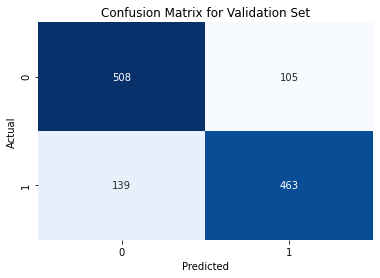

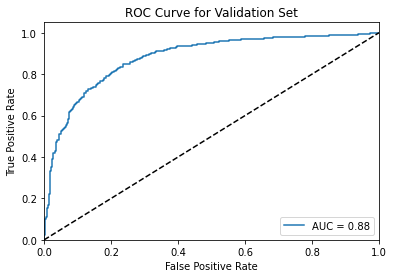

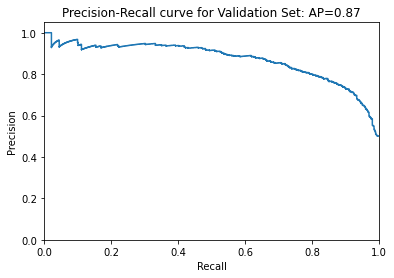

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


def print_metrics(y_true, y_pred, label):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{label} - Accuracy: {accuracy:.4f}")
    print(f"{label} - Precision: {precision:.4f}")
    print(f"{label} - Recall: {recall:.4f}")
    print(f"{label} - F1 Score: {f1:.4f}")

y_train_pred = svm_clf.predict(X_train_selected)
print_metrics(y_train, y_train_pred, "Training")

y_val_pred = svm_clf.predict(X_val_selected)
print_metrics(y_val, y_val_pred, "Validation")

X_test_selected = X_test[:, best_features]
y_test_pred = svm_clf.predict(X_test_selected)
print_metrics(y_test, y_test_pred, "Test")

y_val_pred = svm_clf.predict(X_val_selected)

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()

y_val_proba = svm_clf.decision_function(X_val_selected)

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve for Validation Set: AP={average_precision:.2f}')
plt.show()
